# Introduction to Data Science 2022
## Week 4 exercises
### Instructions
For this week’s deep learning exercises we will use the CSC environment.
Follow the instructions below to find and complete the exercises on CSC:
- Start by going to the CSC notebooks. Choose the Haka login option and
log in using your University credentials.
- Fine the environment “Practical Deep Learning”, and press the start
button to start a new session. After a few seconds, the option will
appear to “Enter session”. This will open a new instance of a Jupyter
environment in your browser.
- Warning: each instance of the environment has a “lifetime” of 4
hours. Remember to save and download the Jupyter notebook(s)
you have been working on, before your progress is lost. You can
then open a new instance of a Jupyter environment and re-upload your
downloaded notebook(s) to keep working on them.

### Exercises
We will work on two different approaches – two different neural networks that
is – for a classification task on the Fashion MNIST data.
Once you are in the “Practical Deep Learning” environment, open the folder
and go to the directory /intro-to-dl/day1/. For each exercise, use the following
notebook file:
1. Multilayer Perceptron (MLP): Open the Jupyter notebook file “02-tf2-
mnist-mlp.ipynb”.
2. Convolutional Neural Network (CNN): Open the Jupyter notebook file
“03-tf2-mnist-cnn.ipynb”.
Follow the examples and complete the tasks using the Fashion MNIST
dataset using:
from tensorflow.keras.datasets import fashion_mnist
data = fashion_mnist.load_data()
In the “Parameter tuning” tasks, feel free to experiment with different
parameters, optimizers and activation functions for your networks – you will
find useful links in the notebooks. Finally, remember to download your two
completed notebooks and upload them on Moodle.

# MNIST handwritten digits classification with MLPs

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using [TensorFlow](https://www.tensorflow.org/) (version $\ge$ 2.0 required) with the [Keras API](https://www.tensorflow.org/guide/keras/overview).

First, the needed imports.

In [3]:
%matplotlib inline

import os
if not os.path.isfile('pml_utils.py'):
  !wget https://raw.githubusercontent.com/csc-training/intro-to-dl/master/day1/pml_utils.py
from pml_utils import show_failures

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model, to_categorical

from distutils.version import LooseVersion as LV

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Tensorflow version: {}, and Keras version: {}.'.format(tf.__version__, tf.keras.__version__))
assert(LV(tf.__version__) >= LV("2.0.0"))

2022-09-28 16:20:20.523904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-28 16:20:20.523960: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Using Tensorflow version: 2.8.0, and Keras version: 2.8.0.


/tmp/ipykernel_647/1741857118.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  assert(LV(tf.__version__) >= LV("2.0.0"))


Let's check if we have GPU available.

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    from tensorflow.python.client import device_lib
    for d in device_lib.list_local_devices():
        if d.device_type == 'GPU':
            print('GPU', d.physical_device_desc)
else:
    print('No GPU, using CPU instead.')

No GPU, using CPU instead.


2022-09-28 16:20:22.594879: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-28 16:20:22.594959: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-28 16:20:22.595016: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nb-sherry-the-dark-6b8c587574-vdtq7): /proc/driver/nvidia/version does not exist


## MNIST data set

Next we'll load the MNIST handwritten digits data set using TensorFlow's own tools.  First time we may have to download the data, which can take a while.

#### Altenative: Fashion-MNIST

Alternatively, MNIST can be replaced with Fashion-MNIST, which can be used as drop-in replacement for MNIST.   Fashion-MNIST contains images of 10 fashion categories:

Label|Description|Label|Description
--- | --- |--- | ---
0|T-shirt/top|5|Sandal
1|Trouser|6|Shirt
2|Pullover|7|Sneaker
3|Dress|8|Bag
4|Coat|9|Ankle boot


In [5]:
from tensorflow.keras.datasets import mnist, fashion_mnist

## MNIST:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
## Fashion-MNIST:
#(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

nb_classes = 10

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

# one-hot encoding:
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

print()
print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Y_train:', Y_train.shape)


MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 28, 28)
y_train: (60000,)
Y_train: (60000, 10)


The training data (`X_train`) is a 3rd-order tensor of size (60000, 28, 28), i.e. it consists of 60000 images of size 28x28 pixels. `y_train` is a 60000-dimensional vector containing the correct classes ("0", "1", ..., "9") for each training sample, and `Y_train` is a [one-hot](https://en.wikipedia.org/wiki/One-hot) encoding of `y_train`.

Let's take a closer look. Here are the first 10 training digits (or fashion items for Fashion-MNIST):

Training sample 0 : class: 5 , one-hot encoded: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Training sample 1 : class: 0 , one-hot encoded: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 2 : class: 4 , one-hot encoded: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Training sample 3 : class: 1 , one-hot encoded: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 4 : class: 9 , one-hot encoded: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Training sample 5 : class: 2 , one-hot encoded: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Training sample 6 : class: 1 , one-hot encoded: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 7 : class: 3 , one-hot encoded: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Training sample 8 : class: 1 , one-hot encoded: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Training sample 9 : class: 4 , one-hot encoded: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


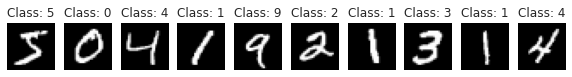

In [6]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:], cmap="gray")
    plt.title('Class: '+str(y_train[i]))
    print('Training sample',i,': class:',y_train[i], ', one-hot encoded:', Y_train[i])

## Multi-layer perceptron (MLP) network

Let's create an MLP model that has multiple layers, non-linear activation functions, and optionally dropout layers for regularization.

### Initialization

We first create the `Input` of shape 28x28 to match the size of the input data. Then we use a `Flatten` layer to convert the 2D image data into vectors of size 784.

We add a `Dense` layer that has 20 output nodes. The `Dense` layer connects each input to each output with some weight parameter and then passes the result through a ReLU non-linear activation function.

The output of the last layer needs to be a softmaxed 10-dimensional vector to match the ground truth (`Y_train`).  This means that it will output 10 values between 0 and 1 which sum to 1, hence, together they can be interpreted as a probability distribution over our 10 classes.

After all layers are created, we create the `Model` by specifying its inputs and outputs.

Finally, we select *categorical crossentropy* as the loss function, select [*adam*](https://keras.io/api/optimizers/adam/) as the optimizer, add *accuracy* to the list of metrics to be evaluated, and `compile()` the model.  Adam is simply a an advanced version of stochastic gradient descent, note there are [several different options](https://keras.io/optimizers/) for the optimizer in Keras that we could use instead of *adam*.

In [7]:
# Model initialization:
inputs = keras.Input(shape=(28, 28))
x = layers.Flatten()(inputs)

# A simple model:
x = layers.Dense(units=20, activation="relu")(x)

# The last layer needs to be like this:
outputs = layers.Dense(units=10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs,
                    name="mlp_model")
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
print(model.summary())

Model: "mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 20)                15700     
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
None


2022-09-28 16:20:26.197921: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The summary shows that there are 15,910 parameters in total in our model.

For example for the first dense layer we have 785x20 = 15,700 parameters as the weight matrix is of size 785x20 (not 784, as there's an additional bias term).

We can also draw a fancier graph of our model.

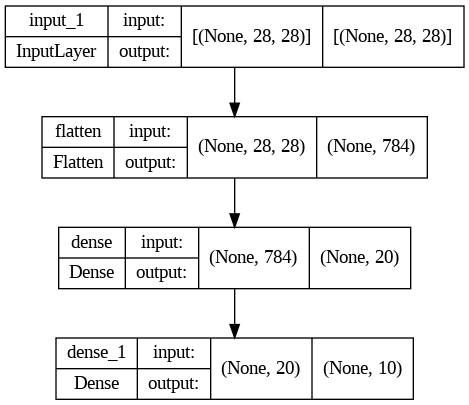

In [8]:
plot_model(model, show_shapes=True)

### Learning

Next, we'll train our model.  Notice how the interface is similar to scikit-learn: we still call the `fit()` method on our model object.

An *epoch* means one pass through the whole training data, we'll begin by running training for 10 epochs.

You can run code below multiple times and it will continue the training process from where it left off.  If you want to start from scratch, re-initialize the model using the code a few cells ago. 

We use a batch size of 32, so the actual input will be 32x784 for each batch of 32 images.

In [9]:
%%time
epochs = 10

history = model.fit(X_train, Y_train, 
                    epochs=epochs, 
                    batch_size=32,
                    verbose=2)

Epoch 1/10
1875/1875 - 5s - loss: 0.4090 - accuracy: 0.8862 - 5s/epoch - 3ms/step
Epoch 2/10
1875/1875 - 5s - loss: 0.2231 - accuracy: 0.9350 - 5s/epoch - 3ms/step
Epoch 3/10
1875/1875 - 5s - loss: 0.1887 - accuracy: 0.9455 - 5s/epoch - 3ms/step
Epoch 4/10
1875/1875 - 5s - loss: 0.1678 - accuracy: 0.9509 - 5s/epoch - 3ms/step
Epoch 5/10
1875/1875 - 6s - loss: 0.1538 - accuracy: 0.9552 - 6s/epoch - 3ms/step
Epoch 6/10
1875/1875 - 5s - loss: 0.1420 - accuracy: 0.9581 - 5s/epoch - 2ms/step
Epoch 7/10
1875/1875 - 5s - loss: 0.1346 - accuracy: 0.9601 - 5s/epoch - 3ms/step
Epoch 8/10
1875/1875 - 5s - loss: 0.1274 - accuracy: 0.9621 - 5s/epoch - 3ms/step
Epoch 9/10
1875/1875 - 4s - loss: 0.1216 - accuracy: 0.9640 - 4s/epoch - 2ms/step
Epoch 10/10
1875/1875 - 4s - loss: 0.1179 - accuracy: 0.9648 - 4s/epoch - 2ms/step
CPU times: user 1min 6s, sys: 14.8 s, total: 1min 21s
Wall time: 49.5 s


Let's now see how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the training data.  It gives some indication of the real accuracy of the model but cannot be fully trusted, as it may have overfitted and just memorizes the training data.

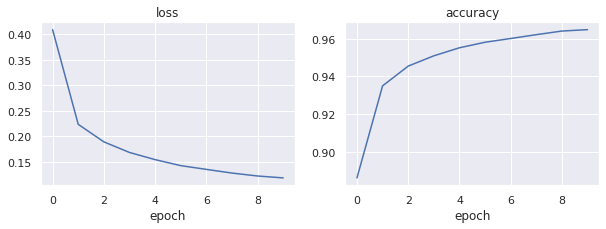

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

ax1.plot(history.epoch,history.history['loss'])
ax1.set_title('loss')
ax1.set_xlabel('epoch')

ax2.plot(history.epoch,history.history['accuracy'])
ax2.set_title('accuracy')
ax2.set_xlabel('epoch');

### Inference

For a better measure of the quality of the model, let's see the model accuracy for the test data. 

In [11]:
%%time
scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

313/313 - 1s - loss: 0.1475 - accuracy: 0.9592 - 848ms/epoch - 3ms/step
accuracy: 95.92%
CPU times: user 1.06 s, sys: 162 ms, total: 1.22 s
Wall time: 1.53 s


We can now take a closer look at the results using the `show_failures()` helper function.

Here are the first 10 test digits the MLP classified to a wrong class:

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


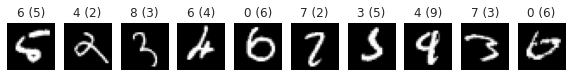

In [12]:
predictions = model.predict(X_test)

show_failures(predictions, y_test, X_test)

We can use `show_failures()` to inspect failures in more detail. For example, here are failures in which the true class was "6":

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


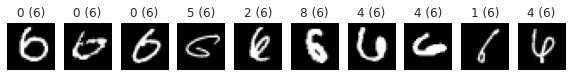

In [13]:
show_failures(predictions, y_test, X_test, trueclass=6)

We can also compute the confusion matrix to see which digits get mixed the most, and look at classification accuracies separately for each class:

In [14]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

[[ 960    0    4    1    3    4    6    1    1    0]
 [   0 1117    2    2    1    1    4    1    7    0]
 [   7    0 1001    4    3    1    1    6    8    1]
 [   1    1   12  963    0   11    2    6   11    3]
 [   2    0    6    0  953    3    7    1    2    8]
 [   2    1    1   10    3  853   13    0    7    2]
 [   4    2    4    0    7    8  930    0    3    0]
 [   2    3   23   10    7    1    2  964    4   12]
 [   6    3    5   13    6   12   13    2  907    7]
 [   8    6    1   12   21    7    0    6    4  944]]

Classification accuracy for each class:

0: 0.9796
1: 0.9841
2: 0.9700
3: 0.9535
4: 0.9705
5: 0.9563
6: 0.9708
7: 0.9377
8: 0.9312
9: 0.9356


## Task 1: Model with two dense layers

Your task is to try the same problem as above, but with a more complex model. The new model should have **two dense layers**, each with:

- 50 units
- ReLU activation
- each followed by a dropout layer with a rate of 0.2

Dropout randomly sets a fraction of inputs to zero during training, which is one approach to regularization and can sometimes help to prevent overfitting.

You can consult the Keras documentation at https://keras.io/.  For example, the Dense, Activation, and Dropout layers are described at https://keras.io/layers/core/.

The code below is missing the model definition. You can copy any suitable layers from the example above.

In [15]:
ex1_inputs = keras.Input(shape=(28, 28))

x = layers.Flatten()(ex1_inputs)
x = layers.Dense(units=50, activation="relu")(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Dense(units=50, activation="relu")(x)
x = layers.Dropout(rate=0.2)(x)

ex1_outputs = layers.Dense(units=10, activation='softmax')(x)

Execute cell to see the [example answer](https://raw.githubusercontent.com/csc-training/intro-to-dl/master/day1/solutions/tf2-mnist-mlp-example-answer.py). 
Note: in Google Colab you have to click and copy the answer manually.

In [ ]:
%load solutions/tf2-mnist-mlp-example-answer.py

In [16]:
assert ex1_outputs is not None, "You need to write the missing model definition"

ex1_model = keras.Model(inputs=ex1_inputs, outputs=ex1_outputs,
                        name="two_layer_mlp_model")
ex1_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
print(ex1_model.summary())

Model: "two_layer_mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                39250     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 10)        

In [17]:
%%time
ex1_epochs = 10
ex1_history = ex1_model.fit(X_train, Y_train, 
                            epochs=epochs, 
                            batch_size=32,
                            verbose=2)

Epoch 1/10
1875/1875 - 7s - loss: 0.4548 - accuracy: 0.8612 - 7s/epoch - 4ms/step
Epoch 2/10
1875/1875 - 7s - loss: 0.2514 - accuracy: 0.9256 - 7s/epoch - 4ms/step
Epoch 3/10
1875/1875 - 6s - loss: 0.2019 - accuracy: 0.9394 - 6s/epoch - 3ms/step
Epoch 4/10
1875/1875 - 6s - loss: 0.1810 - accuracy: 0.9470 - 6s/epoch - 3ms/step
Epoch 5/10
1875/1875 - 7s - loss: 0.1665 - accuracy: 0.9496 - 7s/epoch - 4ms/step
Epoch 6/10
1875/1875 - 6s - loss: 0.1542 - accuracy: 0.9531 - 6s/epoch - 3ms/step
Epoch 7/10
1875/1875 - 6s - loss: 0.1444 - accuracy: 0.9553 - 6s/epoch - 3ms/step
Epoch 8/10
1875/1875 - 4s - loss: 0.1417 - accuracy: 0.9568 - 4s/epoch - 2ms/step
Epoch 9/10
1875/1875 - 4s - loss: 0.1371 - accuracy: 0.9582 - 4s/epoch - 2ms/step
Epoch 10/10
1875/1875 - 4s - loss: 0.1314 - accuracy: 0.9600 - 4s/epoch - 2ms/step
CPU times: user 1min 33s, sys: 24.7 s, total: 1min 58s
Wall time: 56.4 s


Let's plot the data to see how the training progressed. A big gap between training and validation accuracies would suggest overfitting.

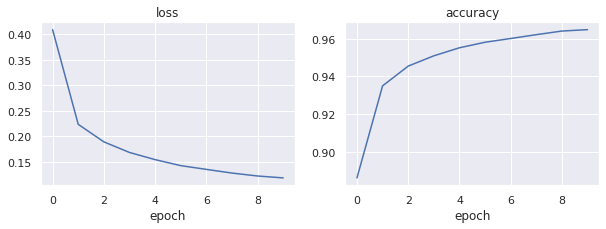

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

ax1.plot(history.epoch,history.history['loss'])
ax1.set_title('loss')
ax1.set_xlabel('epoch')

ax2.plot(history.epoch,history.history['accuracy'])
ax2.set_title('accuracy')
ax2.set_xlabel('epoch');

In [19]:
ex1_scores = ex1_model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (ex1_model.metrics_names[1], ex1_scores[1]*100))

313/313 - 1s - loss: 0.1012 - accuracy: 0.9700 - 709ms/epoch - 2ms/step
accuracy: 97.00%


## Task 2: Model tuning

Modify the MLP model.  Try to improve the classification accuracy, or experiment with the effects of different parameters.  If you are interested in the state-of-the-art performance on permutation invariant MNIST, see e.g. [this paper](https://arxiv.org/abs/1507.02672) by Aalto University / The Curious AI Company researchers.

You can also consult the Keras documentation at https://keras.io/.  For example, the Dense, Activation, and Dropout layers are described at https://keras.io/layers/core/.

<hr/>

*Run this notebook in Google Colaboratory using [this link](https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/02-tf2-mnist-mlp.ipynb).*

In [20]:
ex2_inputs = keras.Input(shape=(28, 28))

# Adding in another similar layer
x = layers.Flatten()(ex2_inputs)
x = layers.Dense(units=50, activation="relu")(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Dense(units=50, activation="relu")(x)
x = layers.Dropout(rate=0.2)(x)
x = layers.Dense(units=50, activation="relu")(x)
x = layers.Dropout(rate=0.2)(x)

ex2_outputs = layers.Dense(units=10, activation='softmax')(x)


ex2_model = keras.Model(inputs=ex2_inputs, outputs=ex2_outputs,
                        name="two_layer_mlp_model")
ex2_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
print(ex2_model.summary())

Model: "two_layer_mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 50)                39250     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                2550      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 50)        

In [21]:
%%time
ex2_epochs = 10
ex2_history = ex2_model.fit(X_train, Y_train, 
                            epochs=epochs, 
                            batch_size=32,
                            verbose=2)

Epoch 1/10
1875/1875 - 5s - loss: 0.4995 - accuracy: 0.8454 - 5s/epoch - 3ms/step
Epoch 2/10
1875/1875 - 7s - loss: 0.2616 - accuracy: 0.9237 - 7s/epoch - 4ms/step
Epoch 3/10
1875/1875 - 7s - loss: 0.2172 - accuracy: 0.9367 - 7s/epoch - 4ms/step
Epoch 4/10
1875/1875 - 5s - loss: 0.1971 - accuracy: 0.9434 - 5s/epoch - 3ms/step
Epoch 5/10
1875/1875 - 5s - loss: 0.1811 - accuracy: 0.9456 - 5s/epoch - 3ms/step
Epoch 6/10
1875/1875 - 6s - loss: 0.1717 - accuracy: 0.9498 - 6s/epoch - 3ms/step
Epoch 7/10
1875/1875 - 7s - loss: 0.1591 - accuracy: 0.9529 - 7s/epoch - 4ms/step
Epoch 8/10
1875/1875 - 7s - loss: 0.1551 - accuracy: 0.9541 - 7s/epoch - 4ms/step
Epoch 9/10
1875/1875 - 7s - loss: 0.1483 - accuracy: 0.9565 - 7s/epoch - 4ms/step
Epoch 10/10
1875/1875 - 5s - loss: 0.1413 - accuracy: 0.9581 - 5s/epoch - 3ms/step
CPU times: user 1min 47s, sys: 29.6 s, total: 2min 16s
Wall time: 1min 1s


In [22]:
ex2_scores = ex2_model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (ex2_model.metrics_names[1], ex2_scores[1]*100))

313/313 - 1s - loss: 0.1006 - accuracy: 0.9716 - 787ms/epoch - 3ms/step
accuracy: 97.16%


Comparing this second round to the first, we have that for the first we had: 
    - First: 313/313 - 1s - loss: 0.1012 - accuracy: 0.9700 - 709ms/epoch - 2ms/step accuracy: 97.00%
    - Second: 313/313 - 1s - loss: 0.1006 - accuracy: 0.9716 - 787ms/epoch - 3ms/step
accuracy: 97.16%
  
So there is a very slight increase in accuracy with the additional layer, although not by much. 